****
# Deep Q-Learning Network with Keras and OpenAI Gym
****
<p style="text-align: right"><i>Jesus Perez Colino<br>First version: Jan. 2018<br></i></p>


## About this notebook: 
****
Notebook prepared by **Jesus Perez Colino** Version 0.2, First Released: 25/01/2018, Alpha

- This work is licensed under a [Creative Commons Attribution-ShareAlike 3.0 Unported License](http://creativecommons.org/licenses/by-sa/3.0/deed.en_US). This work is offered for free, with the hope that it will be useful.


In [2]:
import os
import random
import gym
import numpy as np
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from collections import deque
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import watermark

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import warnings
warnings.filterwarnings('ignore')

%load_ext watermark
%matplotlib inline

print(' Reproducibility conditions for this notebook '.center(85,'-'))
%watermark -n -v -m -p numpy,scipy,tensorflow,keras,gym,matplotlib,sklearn,pandas
print('-'*85)

-------------------- Reproducibility conditions for this notebook -------------------
Sun Dec 01 2019 

CPython 3.7.3
IPython 7.6.1

numpy 1.16.4
scipy 1.2.1
tensorflow 1.14.0
keras 2.2.4
gym 0.15.4
matplotlib 3.1.0
sklearn 0.21.2
pandas 0.24.2

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit
-------------------------------------------------------------------------------------


## Loading the CartPole OpenAI environment

In [3]:
name_env = 'CartPole-v0'
batch_size = 64
n_episodes = 50

env = gym.make(name_env)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

output_dir = 'model_output/cartpole/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [4]:
if isinstance(env, gym.wrappers.time_limit.TimeLimit):
    print(' OpenAI Enviroment Succesfully Loaded '.center(100,'-'))
    print(f'Env. class name: {env.class_name()} ' )
    print(f'Env. action space: {str(env.action_space.n)}' )
    print(f'Env. observation space: {env.observation_space.shape[0]}' )
    print(f'Batch size: {batch_size}')
    print(f'Number of episodes: {n_episodes}' )
    print(f'Directory for the model output: {output_dir}')
    print('-'*100)

------------------------------- OpenAI Enviroment Succesfully Loaded -------------------------------
Env. class name: TimeLimit 
Env. action space: 2
Env. observation space: 4
Batch size: 64
Number of episodes: 50
Directory for the model output: model_output/cartpole/
----------------------------------------------------------------------------------------------------


In [5]:
obs = env.reset()
obs

array([ 0.01187962,  0.04814167, -0.01811793,  0.03977068])

The observation is a 1D NumPy array composed of 4 floats: they represent the cart's horizontal position, its velocity, the angle of the pole (0 = vertical), and the angular velocity. 


In [6]:

#from  PIL import  Image,  ImageDraw
try:
    from pyglet.gl import gl_info
    openai_cart_pole_rendering = True   # no problem, let's use OpenAI gym's rendering function
except Exception:
    openai_cart_pole_rendering = False  # probably no X server available, let's use our own rendering function

def render_cart_pole(env, obs):
    if openai_cart_pole_rendering:
        # use OpenAI gym's rendering function
        return env.render(mode="rgb_array")
    else:
        # rendering for the cart pole environment (in case OpenAI gym can't do it)
        img_w = 600
        img_h = 400
        cart_w = img_w // 12
        cart_h = img_h // 15
        pole_len = img_h // 3.5
        pole_w = img_w // 80 + 1
        x_width = 2
        max_ang = 0.2
        bg_col = (255, 255, 255)
        cart_col = 0x000000 # Blue Green Red
        pole_col = 0x669acc # Blue Green Red

        pos, vel, ang, ang_vel = obs
        img = Image.new('RGB', (img_w, img_h), bg_col)
        draw = ImageDraw.Draw(img)
        cart_x = pos * img_w // x_width + img_w // x_width
        cart_y = img_h * 95 // 100
        top_pole_x = cart_x + pole_len * np.sin(ang)
        top_pole_y = cart_y - cart_h // 2 - pole_len * np.cos(ang)
        draw.line((0, cart_y, img_w, cart_y), fill=0)
        draw.rectangle((cart_x - cart_w // 2, cart_y - cart_h // 2, cart_x + cart_w // 2, cart_y + cart_h // 2), fill=cart_col) # draw cart
        draw.line((cart_x, cart_y - cart_h // 2, top_pole_x, top_pole_y), fill=pole_col, width=pole_w) # draw pole
        return np.array(img)

def plot_cart_pole(env, obs):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    img = render_cart_pole(env, obs)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

(-0.5, 599.5, 399.5, -0.5)

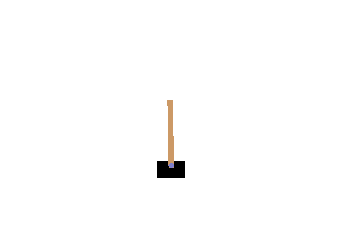

In [7]:
plt.close()  # or else nbagg sometimes plots in the previous cell
img = render_cart_pole(env, obs)
plt.imshow(img)
plt.axis("off")

## Using Deep Q-Learning (aprox. Q-value using DNN) to define a Learning Agent in an Enviroment

In [8]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000) # double-ended queue; acts like list, but elements can be added/removed from either end
        self.gamma = 0.95 # decay or discount rate: enables agent to take into account future actions in addition to the immediate ones, but discounted at this rate
        self.epsilon = 1.0 # exploration rate: how much to act randomly; more initially than later due to epsilon decay
        self.epsilon_decay = 0.995 # decrease number of random explorations as the agent's performance (hopefully) improves over time
        self.epsilon_min = 0.01 # minimum amount of random exploration permitted
        self.learning_rate = 0.01 # rate at which NN adjusts models parameters via SGD to reduce cost 
        self.model = self._build_model() # private method 
    
    def _build_model(self):
        # neural net to approximate Q-value function:
        model = Sequential()
        model.add(Dense(128, input_dim=self.state_size, activation='relu')) # 1st hidden layer; states as input
        # model.add(Dense(64, activation='relu')) # 2nd hidden layer
        model.add(Dense(self.action_size, activation='linear')) # 2 actions, so 2 output neurons: 0 and 1 (L/R)
        model.compile
        model.compile(loss= 'mse', # 'categorical_crossentropy',
                      optimizer=Adam(lr=self.learning_rate))
        return model
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) # list of previous experiences, enabling re-training later

    def act(self, state):
        if np.random.rand() <= self.epsilon: # epsilon greedy policy: exploration vs. explotation
            return random.randrange(self.action_size)
        act_values = self.model.predict(state) # if not acting randomly, predict reward value based on current state
        return np.argmax(act_values[0]) # pick the action that will give the highest reward (i.e., go left or right?)

    def replay(self, batch_size): # method that trains NN with experiences sampled from memory
        minibatch = random.sample(self.memory, batch_size) # sample a minibatch from memory
        for state, action, reward, next_state, done in minibatch: # extract data for each minibatch sample
            target = reward # if done (boolean whether game ended or not, i.e., whether final state or not), then target = reward
            if not done: # if not done, then predict future discounted reward
                target = (reward + self.gamma * # (target) = reward + (discount rate gamma) * 
                          np.amax(self.model.predict(next_state)[0])) # (maximum target Q based on future action a')
            target_f = self.model.predict(state) # approximately map current state to future discounted reward
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0) # single epoch of training with x=state, y=target_f; fit decreases loss btwn target_f and y_hat
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [10]:
agent = DQNAgent(state_size, action_size) # initialise agent

## Making the Agent interact with the Enviroment: Reinforcement Learning

In [11]:
n_episodes = 250
done = False
for e in range(n_episodes): # iterate over new episodes of the game
    state = env.reset() # reset state at start of each new episode of the game
    state = np.reshape(state, [1, state_size])
    
    for time in range(5000):  # time represents a frame of the game; goal is to keep pole upright as long as possible up to range, e.g., 500 or 5000 timesteps
        # env.render()
        action = agent.act(state) # action is either 0 or 1 (move cart left or right); decide on one or other here
        next_state, reward, done, _ = env.step(action) # agent interacts with env, gets feedback; 4 state data points, e.g., pole angle, cart position        
        reward = reward if not done else -10 # reward +1 for each additional frame with pole upright        
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done) # remember the previous timestep's state, actions, reward, etc.        
        state = next_state # set "current state" for upcoming iteration to the current next state        
        if done : # episode ends if agent drops pole or we reach timestep 5000
            print("episode: {}/{}, score: {}, e: {:.2}" # print the episode's score and agent's epsilon
                  .format(e, n_episodes, time, agent.epsilon))
            break # exit loop
    if len(agent.memory) > batch_size:
        agent.replay(batch_size) # train the agent by replaying the experiences of the episode
    if e % 50 == 0:
        agent.save(output_dir + "weights_" + '{:04d}'.format(e) + ".hdf5")

episode: 0/250, score: 14, e: 1.0


episode: 1/250, score: 40, e: 1.0
episode: 2/250, score: 28, e: 1.0
episode: 3/250, score: 31, e: 0.99
episode: 4/250, score: 17, e: 0.99
episode: 5/250, score: 12, e: 0.99
episode: 6/250, score: 13, e: 0.98
episode: 7/250, score: 25, e: 0.98
episode: 8/250, score: 10, e: 0.97
episode: 9/250, score: 12, e: 0.97
episode: 10/250, score: 21, e: 0.96
episode: 11/250, score: 24, e: 0.96
episode: 12/250, score: 12, e: 0.95
episode: 13/250, score: 12, e: 0.95
episode: 14/250, score: 16, e: 0.94
episode: 15/250, score: 25, e: 0.94
episode: 16/250, score: 24, e: 0.93
episode: 17/250, score: 14, e: 0.93
episode: 18/250, score: 11, e: 0.92
episode: 19/250, score: 9, e: 0.92
episode: 20/250, score: 12, e: 0.91
episode: 21/250, score: 16, e: 0.91
episode: 22/250, score: 9, e: 0.9
episode: 23/250, score: 12, e: 0.9
episode: 24/250, score: 9, e: 0.9
episode: 25/250, score: 24, e: 0.89
episode: 26/250, score: 18, e: 0.89
episode: 27/250, score: 51, e: 0.88
episode: 